# Classification With Random Forests Featue Selection

Author: ***Soroush Ghaderi***

In this lesson we will use **scikit-learn** to build **Random Forests Classification** which uses continues and categorical data from [Kaggle](https://www.kaggle.com/) to predict Satisfaction of passengers [Airline Passenger-Satisfaction](https://www.kaggle.com/teejmahal20/airline-passenger-satisfaction).

## What is Random Forests?  
Random forests are an example of an *ensemble* method, meaning that it relies on aggregating the results of an ensemble of simpler estimators. Bagging makes use of an ensemble (a grab bag, perhaps) of parallel estimators, each of which over-fits the data, and averages the results to find a better classification.
An ensemble of randomized decision trees is known as a *random forest*.

In this notebook we will practice about ...

- **Importing Data**


- **Exploratory Data Analysis**


- **Missing Data**

    - Identifying Missing Data
    - Dealing with Missing Data

- **Formatting the Data for Decision Trees**

    - Splitting data into Dependent and Independent Variables
    - One-Hot Encoding

- **Create Complete Pipeline to accelerate the process**


- **Building a Preliminary Random Forests**


- **Tree’s Feature Importance from Mean Decrease in Impurity (MDI)**

    - Visulizing Importance
   
- **Permutation Feature Importance**
       
    - Why we need Permutation in selection of features?

- **Handling Multicollinear Features**

    - Remove redundant features
    
- **PCA as dimensionality reduction**

    - PCA + Random Forests instead of remove redundant features with Permutation Feature Imporance

In [1]:
import helper_cleaning
import helper_visualize
# EDA packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Sklearn Models
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
# Preprocessing and Model Selection
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import QuantileTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix

In [2]:
airline = pd.read_csv("data/train_airline.csv")

In [3]:
# Modify column names and instance values in each column to snake_case
airline.columns = helper_cleaning.standard_column_names(airline)
airline = helper_cleaning.standard_features_string(airline)

In [4]:
airline.head()

,id,gender,customer_type,age,type_of_travel,class,flight_distance,inflight_wifi_service,departure/arrival_time_convenient,ease_of_online_booking,...,inflight_entertainment,on-board_service,leg_room_service,baggage_handling,checkin_service,inflight_service,cleanliness,departure_delay_in_minutes,arrival_delay_in_minutes,satisfaction
0,70172,male,loyal_customer,13,personal_travel,eco_plus,460,3,4,3,...,5,4,3,4,4,5,5,25,18.0,neutral_or_dissatisfied
1,5047,male,disloyal_customer,25,business_travel,business,235,3,2,3,...,1,1,5,3,1,4,1,1,6.0,neutral_or_dissatisfied
2,110028,female,loyal_customer,26,business_travel,business,1142,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,24026,female,loyal_customer,25,business_travel,business,562,2,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral_or_dissatisfied
4,119299,male,loyal_customer,61,business_travel,business,214,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


### Features


**Gender:** Gender of the passengers (Female, Male)  
**Customer Type:** The customer type (Loyal customer, disloyal customer)  
**Age:** The actual age of the passengers  
**Type of Travel:** Purpose of the flight of the passengers (Personal Travel, Business Travel)  
**Class:** Travel class in the plane of the passengers (Business, Eco, Eco Plus)  
**Flight distance:** The flight distance of this journey  
**Inflight wifi service:** Satisfaction level of the inflight wifi service (0:Not Applicable;1-5)  
**Departure/Arrival time convenient:** Satisfaction level of Departure/Arrival time convenient  
**Ease of Online booking:** Satisfaction level of online booking  
**Gate location:** Satisfaction level of Gate location  
**Food and drink:** Satisfaction level of Food and drink  
**Online boarding:** Satisfaction level of online boarding  
**Seat comfort:** Satisfaction level of Seat comfort  
**Inflight entertainment:** Satisfaction level of inflight entertainment  
**On-board service:** Satisfaction level of On-board service  
**Leg room service:** Satisfaction level of Leg room service  
**Baggage handling:** Satisfaction level of baggage handling  
**Check-in service:** Satisfaction level of Check-in service  
**Inflight service:** Satisfaction level of inflight service  
**Cleanliness:** Satisfaction level of Cleanliness  
**Departure Delay in Minutes:** Minutes delayed when departure  
**Arrival Delay in Minutes:** Minutes delayed when Arrival  

### Prediction

***Satisfaction:*** Airline satisfaction level(Satisfaction, neutral or dissatisfaction) 

now we need to investigate missing values and standard(snake_case) values in dataframe.

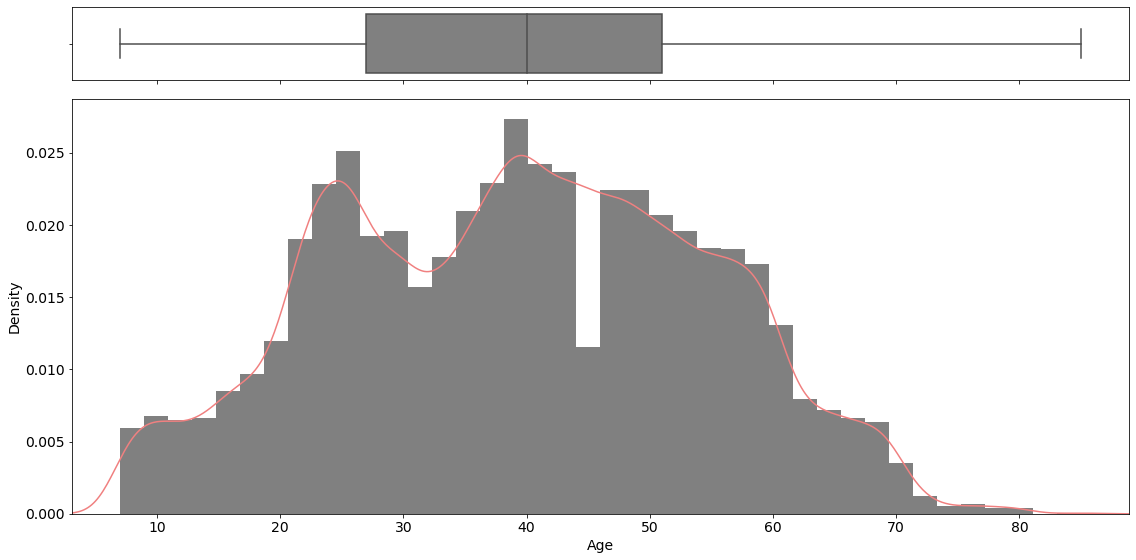

In [5]:
plt.rcParams['font.size'] = 14
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(16, 8))
# boxplot (seaborn)
sns.boxplot(x=airline["age"],color="gray", ax=ax_box)
ax_box.set(xlabel='')
# histogram (matplotlib)
ax_hist.hist(airline["age"], bins=40, density=True, color="gray")
# kde plot (pandas series)
min_, max_ = plt.xlim()
plt.xlim(min_, max_)
airline["age"].plot.kde(color="lightcoral")
ax_hist.set(xlabel='Age')
plt.tight_layout()
plt.show()

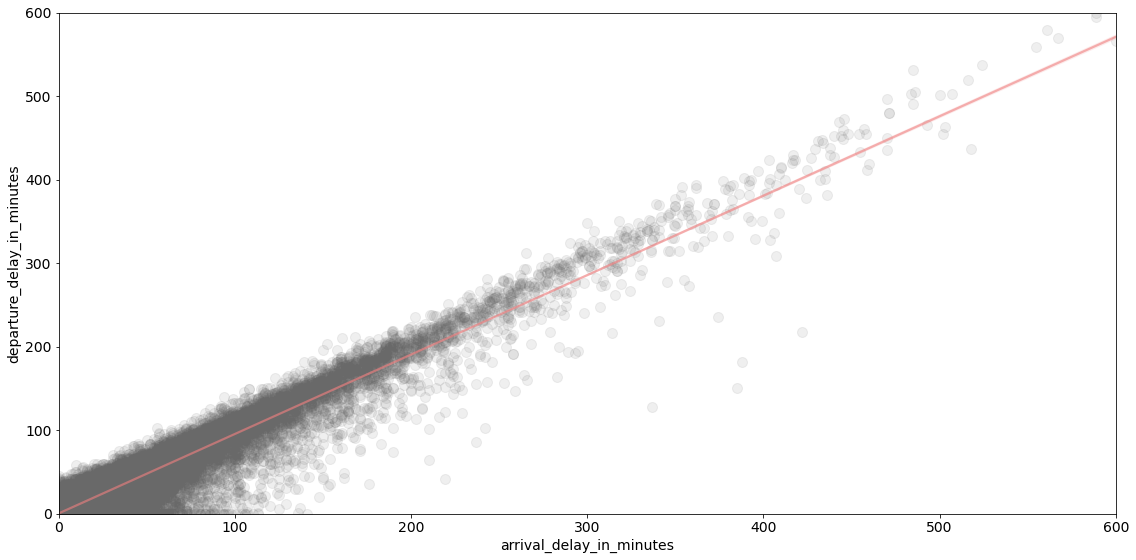

In [6]:
plt.figure(figsize=(16, 8))
sns.regplot(x="arrival_delay_in_minutes", y="departure_delay_in_minutes",data=airline,
            scatter_kws={"s": 100, "color": "dimgray", "alpha":0.1},
            line_kws={"color" : "lightcoral", "alpha":0.6})
plt.xlim(0, 600)
plt.ylim(0, 600)
plt.tight_layout()
plt.show()

In [7]:
delay_per_class = airline.groupby("class").agg({"arrival_delay_in_minutes" : np.mean})

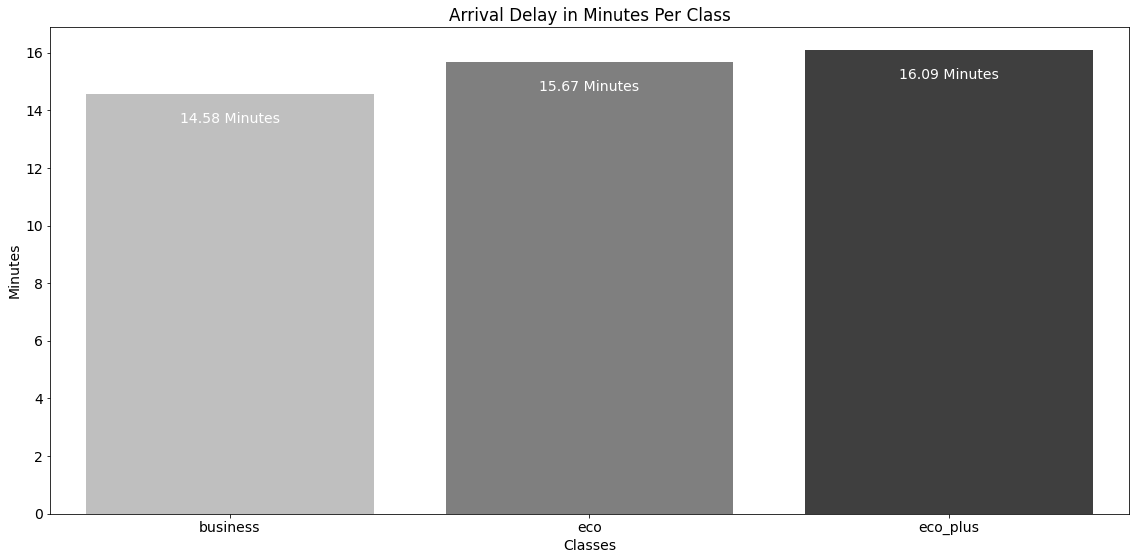

In [8]:
plt.figure(figsize=(16, 8))
sns.barplot(x=delay_per_class.index, y=delay_per_class["arrival_delay_in_minutes"], palette="binary")
xlocs, xlabs = plt.xticks()
for i, v in enumerate(delay_per_class["arrival_delay_in_minutes"]):
    plt.text(xlocs[i], v - 1, str(np.round(v, 2)) + " " + "Minutes", ha = 'center', color="white")
plt.ylabel("Minutes")
plt.xlabel("Classes")
plt.title("Arrival Delay in Minutes Per Class")
plt.tight_layout()
plt.show()

In [12]:
type_satisfaction_customer = pd.crosstab(airline["type_of_travel"], [airline["satisfaction"],
                                         airline["customer_type"]], normalize=True)
satisfied = type_satisfaction_customer.iloc[:, type_satisfaction_customer.columns.get_level_values(0)=='satisfied']
dissatisfied = type_satisfaction_customer.iloc[:, type_satisfaction_customer.columns.get_level_values(0)=='neutral_or_dissatisfied']

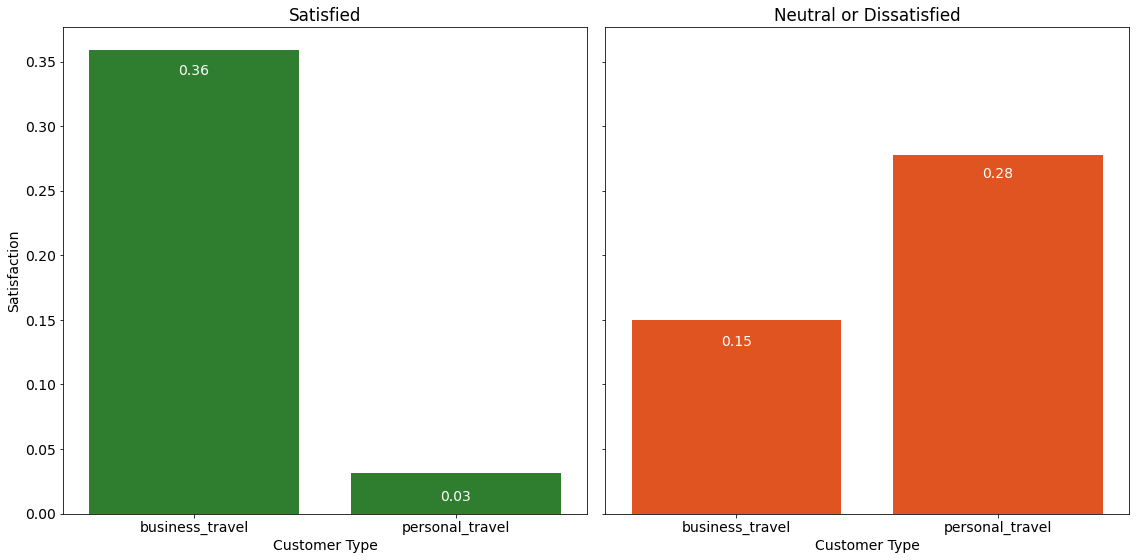

In [15]:
fig, axis = plt.subplots(1, 2, figsize = (16, 8), sharey=True)
satisfied_plot = sns.barplot(x=satisfied.index, y=satisfied["satisfied", "loyal_customer"],
                             data=satisfied, ax = axis[0], palette=["forestgreen", "forestgreen"])
helper_visualize.height_notation(satisfied_plot, - 0.02, satisfied)
satisfied_plot.set_xlabel("Customer Type")
satisfied_plot.set_ylabel("Satisfaction")
satisfied_plot.set_title("Satisfied")

dissatisfied_plot = sns.barplot(x=dissatisfied.index, y=dissatisfied["neutral_or_dissatisfied", "loyal_customer"],
                                data = dissatisfied, ax = axis[1], palette=["orangered", "orangered"])
helper_visualize.height_notation(dissatisfied_plot, - 0.02, dissatisfied)
dissatisfied_plot.set_xlabel("Customer Type")
dissatisfied_plot.set_ylabel("")
dissatisfied_plot.set_title("Neutral or Dissatisfied")
plt.tight_layout()
plt.show()

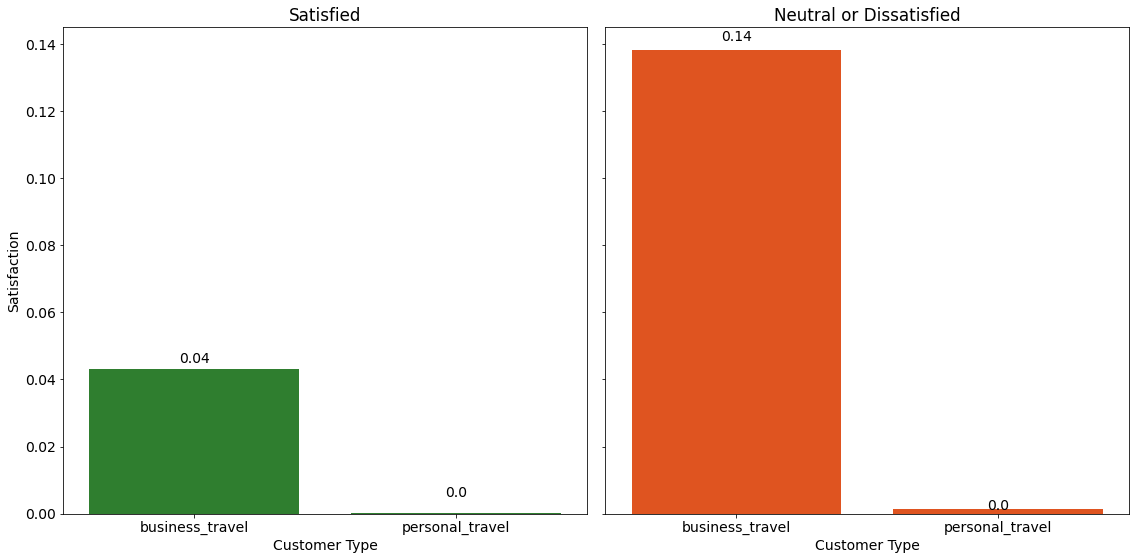

In [18]:
fig, axis = plt.subplots(1, 2, figsize = (16, 8), sharey=True)
satisfied_plot = sns.barplot(x=satisfied.index, y=satisfied["satisfied", "disloyal_customer"],
                             data=satisfied, ax = axis[0], palette=["forestgreen", "forestgreen"])
helper_visualize.height_notation(satisfied_plot, + 0.005, satisfied, color="black")
satisfied_plot.set_xlabel("Customer Type")
satisfied_plot.set_ylabel("Satisfaction")
satisfied_plot.set_title("Satisfied")

dissatisfied_plot = sns.barplot(x=dissatisfied.index, y=dissatisfied["neutral_or_dissatisfied", "disloyal_customer"],
                                data = dissatisfied, ax = axis[1], palette=["orangered", "orangered"])
helper_visualize.height_notation(dissatisfied_plot, + 0.001, dissatisfied, color="black")
dissatisfied_plot.set_xlabel("Customer Type")
dissatisfied_plot.set_ylabel("")
dissatisfied_plot.set_title("Neutral or Dissatisfied")
plt.tight_layout()
plt.show()

In [20]:
gender_satisfaction = pd.crosstab(airline["gender"], airline["satisfaction"], normalize=True)

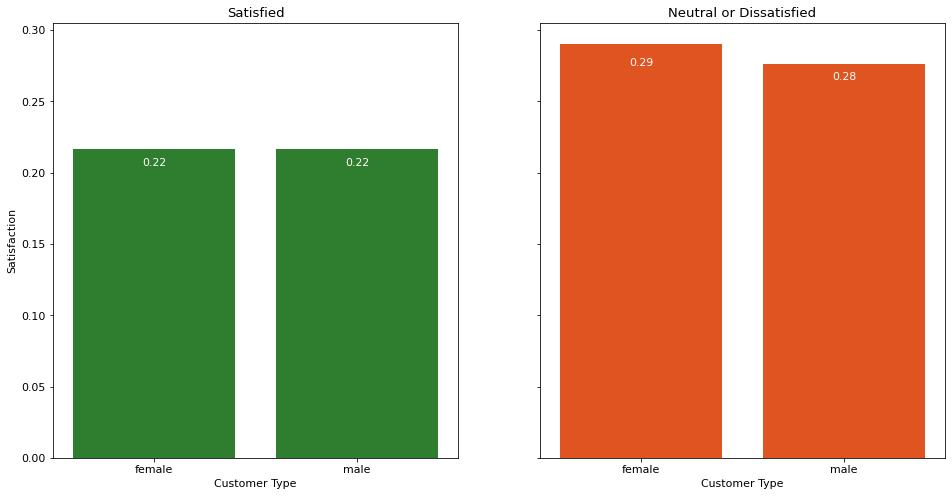

In [22]:
fig, axis = plt.subplots(1, 2, figsize = (16, 8), sharey=True)
satisfied_plot = sns.barplot(x=gender_satisfaction.index, y=gender_satisfaction["satisfied"],
                             data=satisfied, ax = axis[0], palette=["forestgreen", "forestgreen"])
helper_visualize.height_notation(satisfied_plot, - 0.015, satisfied)
satisfied_plot.set_xlabel("Customer Type")
satisfied_plot.set_ylabel("Satisfaction")
satisfied_plot.set_title("Satisfied")

dissatisfied_plot = sns.barplot(x=gender_satisfaction.index, y=gender_satisfaction["neutral_or_dissatisfied"],
                                data = dissatisfied, ax = axis[1], palette=["orangered", "orangered"])
helper_visualize.height_notation(dissatisfied_plot, - 0.015, dissatisfied)
dissatisfied_plot.set_xlabel("Customer Type")
dissatisfied_plot.set_ylabel("")
dissatisfied_plot.set_title("Neutral or Dissatisfied")
plt.show()

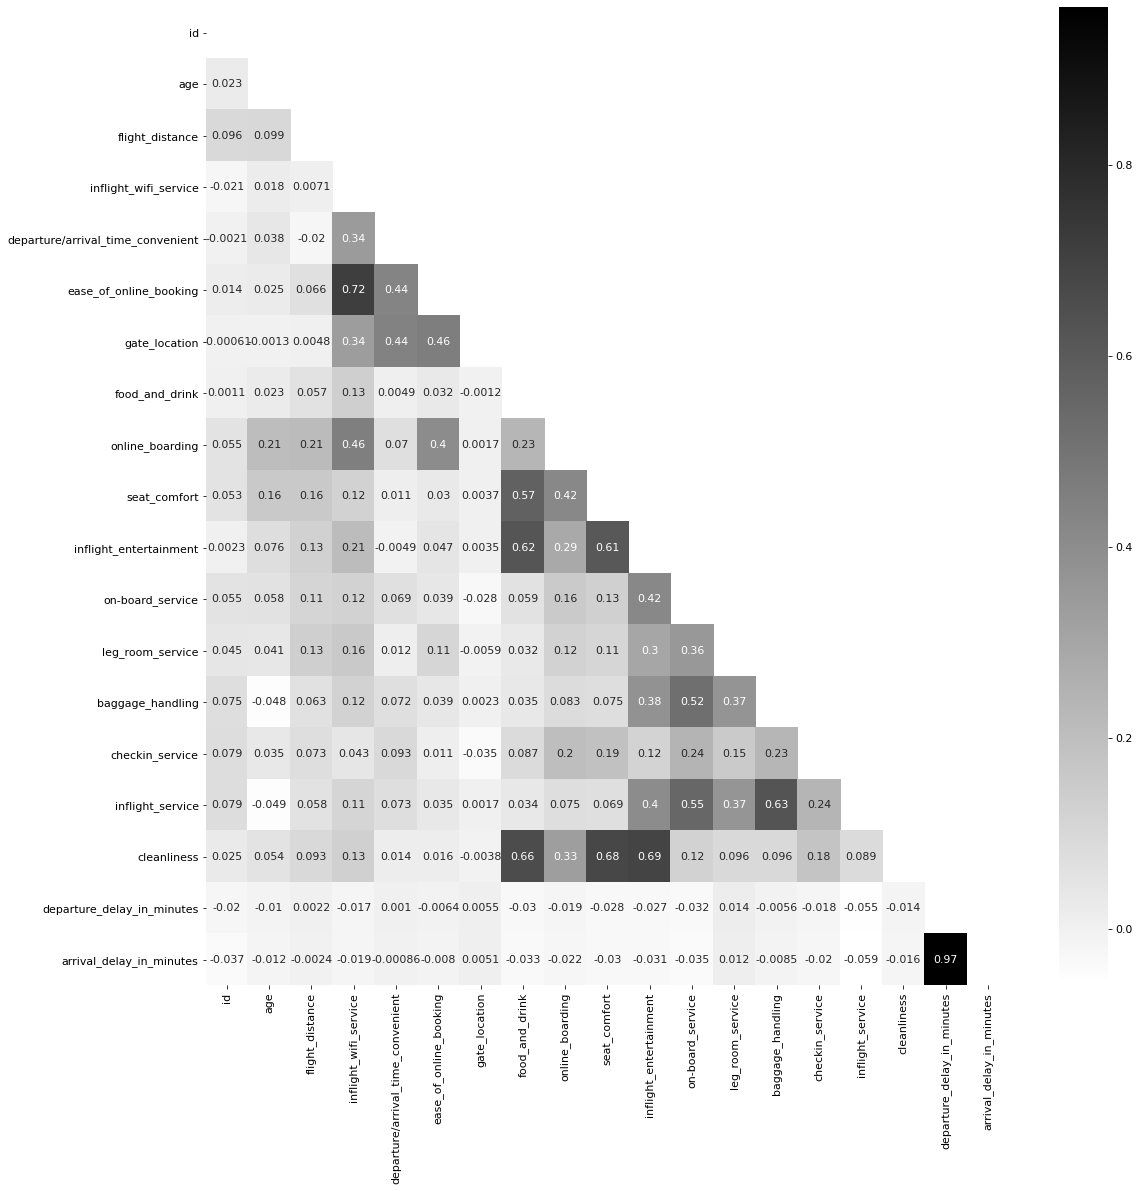

In [19]:
plt.rcParams['font.size'] = 11
plt.figure(figsize=(18, 18))
matrix = np.triu(airline.corr())
sns.heatmap(airline.corr(), annot=True, mask=matrix, cmap="binary")
plt.show()

In [ ]:
airline.info()

- Data types are correct and we dont need to change datatypes. For change datatypes we need astype function to change wrong datatypes. for example a numerical column maybe saved as a object column.

- only **departure_delay_in_minutes** column has missing values, we don't fill or drop this values for now because our complete pipeline will fix this issue.

In [ ]:
airline.isnull().sum()

As we can see, only **310** values in **arrival_delay_in_minutes** are missing and we can drop this columns but filling this values with respect to many observarions doesn't make bias in model.

- We encode satisfaction (predict object) to zero and one
- drop id column cause id is identical number to each passenger and its a random number, so doesn't have any useful information to our prediction model.

In [ ]:
airline["satisfaction"] = airline["satisfaction"].map({"neutral_or_dissatisfied": 0, "satisfied": 1})
airline = airline.drop(["id"], axis=1)

We can build a additional feature with mix of **arrival_delay_in_minutes** and **departure_delay_in_minutes**.

In [ ]:
airline["total_delay"] = airline["arrival_delay_in_minutes"] + airline["departure_delay_in_minutes"]
airline = airline.drop(["arrival_delay_in_minutes", "departure_delay_in_minutes"], axis=1)

# Format Data Part 1: Split the Data into Dependent and Independent  Variables

In [ ]:
X = airline.drop(["satisfaction"], axis=1)
y = airline["satisfaction"]

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                    test_size=0.2, random_state=42)

# Format Data Part 2: Build Pipeline for Categorical and Numerical values

In [ ]:
numerical_features = X_train.select_dtypes(include='number').columns.tolist()
categorical_features = X_train.select_dtypes(exclude='number').columns.tolist()

In [ ]:
numeric_pipeline = Pipeline(steps=[
    ('Imputer', SimpleImputer(strategy='median')),
    ('Scale', QuantileTransformer(n_quantiles=100, output_distribution="uniform"))
])

categorical_pipeline = Pipeline(steps=[
    ('Imputer', SimpleImputer(strategy= "most_frequent")),
    ('One-Hot', OneHotEncoder(handle_unknown='error', sparse=False))
])

In [ ]:
full_processor = ColumnTransformer(transformers=[
    ('number', numeric_pipeline, numerical_features),
    ('category', categorical_pipeline, categorical_features),
    ])

# Building a Preliminary Random Forests

1. Transform data to right format in machine learning  
2. Preliminary Random Forests

In [ ]:
X_train_transform = full_processor.fit_transform(X_train)
X_valid_transform = full_processor.transform(X_valid)
rf_clf = RandomForestClassifier(random_state=1)

In [ ]:
rf_clf.fit(X_train_transform, y_train)
y_pred = rf_clf.predict(X_valid_transform)

In [ ]:
rf_clf_acc_valid = accuracy_score(y_pred, y_valid)
print("Random Forest Validation Accuracy: {:.2f}%".format(rf_clf_acc_valid * 100))

# Test our data with tuned model 

In [ ]:
airline_test = pd.read_csv("data/test_airline.csv")

In [ ]:
airline_test.columns = helper_cleaning.standard_column_names(airline_test)
airline_test = helper_cleaning.standard_features_string(airline_test)

In [ ]:
airline_test.head()

In [ ]:
airline_test["total_delay"] = airline_test["arrival_delay_in_minutes"] + airline_test["departure_delay_in_minutes"]
airline_test = airline_test.drop(["arrival_delay_in_minutes", "departure_delay_in_minutes"], axis=1)

In [ ]:
airline_test["satisfaction"] = airline_test["satisfaction"].map({"neutral_or_dissatisfied": 0, "satisfied":1})
airline_test = airline_test.drop(["id"], axis=1)

In [ ]:
X = airline_test.drop(["satisfaction"], axis=1)
y = airline_test["satisfaction"]

In [ ]:
X_test_transform = full_processor.transform(X)
y_pred_test = rf_clf.predict(X_test_transform)

In [ ]:
rf_clf_acc_test = accuracy_score(y_pred_test, y)
print("Random Forest Test accuracy: {:.2f}%".format(rf_clf_acc_test * 100))

In [ ]:
# plot_confusion_matrix() will run the test data down the tree and draw confusion matrix.
plot_confusion_matrix(rf_clf, X_test_transform,
                      y, display_labels=["Not Satisfied", "Satisfied"],
                      values_format= "d")
plt.show()

## Tree’s Feature Importance from Mean Decrease in Impurity (MDI)

The impurity-based feature importance ranks the numerical features to be the most important features.
This problem stems from two limitations of impurity-based feature importances:

- impurity-based importances are biased towards high cardinality features;

- impurity-based importances are computed on training set statistics and therefore do not reflect the ability of feature to be useful to make predictions that generalize to the test set (when the model has enough capacity).

In [ ]:
feature_names = helper_cleaning.get_feature_names_mixture_column_transformer(
    full_processor,
    categorical_features,
    "number",
    "category")
importances = rf_clf.feature_importances_

In [ ]:
forest_importances = pd.Series(importances, index=feature_names)
forest_importances.sort_values(ascending=False, inplace=True)
importance_mask = np.where(forest_importances > .07, 1, 0)

In [ ]:
color_important = ["lightcoral" if important == 1 else "gray" for important, value in zip(importance_mask, forest_importances)]

In [ ]:
plt.figure(figsize=(15, 8))
sns.barplot(x=forest_importances.index, y=forest_importances.values,
            palette=color_important)
plt.title("Feature importances using MDI")
plt.ylabel("Importance")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Permutation Feature Importance

Permutation feature importance measures the increase in the prediction error of the model after we permuted the feature's values, which breaks the relationship between the feature and the true outcome.  
The concept is really straightforward: We measure the importance of a feature by calculating the increase in the model's prediction error after permuting the feature.  
- A feature is **"important"** if shuffling its values increases the model error, because in this case the model relied on the feature for the prediction.  
- A feature is **"unimportant"** if shuffling its values leaves the model error unchanged, because in this case the model ignored the feature for the prediction.  


The permutation feature importance measurement was introduced by Breiman (2001) for random forests. Based on this idea, Fisher, Rudin, and Dominici (2018) proposed a model-agnostic version of the feature importance and called it model reliance. They also introduced more advanced ideas about feature importance, for example a (model-specific) version that takes into account that many prediction models may predict the data well.

In [ ]:
result = permutation_importance(
    rf_clf, X_train_transform, y_train, n_repeats=10, random_state=42)

forest_importances_permutation = pd.Series(result.importances_mean, index=feature_names)
forest_importances_permutation.sort_values(ascending=False, inplace=True)

In [ ]:
plt.figure(figsize=(15, 8))
sns.barplot(x=forest_importances_permutation.index, y=forest_importances_permutation.values,
            palette=color_important)
plt.title("Feature importances using permutation on full model")
plt.ylabel("Mean accuracy decrease")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Handling Multicollinear Features

When features are collinear, permutating one feature will have little effect on the models performance because it can get the same information from a correlated feature. One way to handle multicollinear features is by **performing hierarchical clustering on the Spearman rank-order correlations, picking a threshold, and keeping a single feature from each cluster.**  
First, we plot a heatmap of the correlated features:

In [ ]:
from collections import defaultdict

from scipy.stats import spearmanr
from scipy.cluster import hierarchy

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X_train_transform).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(
    corr_linkage, labels=feature_names, ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
fig.tight_layout()
plt.show()

Next, we manually pick a threshold by visual inspection of the dendrogram to group our features into clusters and choose a feature from each cluster to keep, select those features from our dataset, and train a new random forest. The test accuracy of the new random forest did not change much compared to the random forest trained on the complete dataset.

In [ ]:
cluster_ids = hierarchy.fcluster(corr_linkage, 1, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

X_train_sel = X_train_transform[:, selected_features]
X_valid_sel = X_valid_transform[:, selected_features]

clf_sel = RandomForestClassifier(n_estimators=100, random_state=42)
clf_sel.fit(X_train_sel, y_train)
print("Accuracy on Validation data with features removed: {:.2f} %".format(
      clf_sel.score(X_valid_sel, y_valid) * 100))

In [ ]:
name_of_selected_features = [feature_names[idx] for idx in selected_features]
print("Removed Features: {}".format(
    len(feature_names) - len(name_of_selected_features)))
print("Remaining Features: {}".format(
    len(name_of_selected_features)))

In [ ]:

X_test_sel = X_test_transform[:, selected_features]

In [ ]:
# plot_confusion_matrix() will run the test data down the tree and draw confusion matrix.
plot_confusion_matrix(clf_sel, X_test_sel,
                      y, display_labels=["Not Satisfied", "Satisfied"])
plt.show()

Reduction

In [ ]:
pca = PCA() # by default, PCA centers the data, but does not scale it.
X_train_pca = pca.fit_transform(X_train_scaled)

fig, axis = plt.subplots(1, 2, figsize = (16, 8))

per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
labels = [str(x) for x in range(1, len(per_var) + 1)]

plt.bar(x= range(1, len(per_var) + 1), height= per_var)
plt.tick_params(axis = "x", # changes apply to the x-axis
                which = "both", # both major and minor ticks are affected
                bottom = False, # ticks along the bottom edge are off
                top= False, # tick along the top edge are off
                labelbottom= False) # labels along the bottom edge are off
plt.ylabel("Percentage of Explained Variance")
plt.xlabel("Principal Components")
plt.title("Scree Plot")
plt.show()

In [ ]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train_transform)
# Left plot -> 
per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
labels = [str(x) for x in range(1, len(per_var) + 1)]


fig, axis = plt.subplots(1, 2, figsize = (16, 8))



axis[0].bar(x= range(1, len(per_var) + 1), height= per_var)
axis[0].set_ylabel("Percentage of Explained Variance")
axis[0].set_xlabel("Principal Components")
axis[0].set_title("Scree Plot")

# Right plot
cum_sum_eigenvalues = np.cumsum(pca.explained_variance_ratio_)
axis[1].step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues , where='mid',label='Cumulative explained variance')
axis[1].set_xlabel('Number of Components')
axis[1].set_ylabel('Cumulative Explained Variance');

plt.tight_layout()
plt.show()

In [ ]:
pca = PCA(n_components=15)
X_train_pca = pca.fit_transform(X_train_transform)
X_valid_pca = pca.transform(X_valid_transform)

In [ ]:
rf_clf = RandomForestClassifier(random_state=1)
rf_clf.fit(X_train_pca, y_train)
y_pred = rf_clf.predict(X_valid_pca)

In [ ]:
rf_clf_pca = accuracy_score(y_pred, y_valid)
print("Random Forest with PCA Vaidation accuracy: {:.2f}%".format(rf_clf_pca * 100))

In [ ]:
X_test_pca = pca.transform(X_test_transform)

In [ ]:
# plot_confusion_matrix() will run the test data down the tree and draw confusion matrix.
plot_confusion_matrix(rf_clf, X_test_pca,
                      y, display_labels=["Not Satisfied", "Satisfied"],
                      values_format= "d")
plt.show()